# Tutorial 2 - Topic & Sentiment Distributions

This notebook explores distributions of CAP categories and sentiment in parliamentary speeches across countries, based on the ParlaMint corpus. 

**Possible research questions:**
- *Which CAP categories dominate parliamentary debates, and does the distribution differ across countries?*
- *How does average sentiment vary by topic and by country*
- *Do party affiliation or coalition status influence the tone of debates?*

It includes:
- **Histograms and barplots** showing the **distribution of CAP categories** across parliaments
- **Sentiment distributions** for individual topics within a single country and across all countries
- **Sentiment distributions by party status** (Coalition vs. Opposition)
- **Tables summarizing average sentiment** by topic and country, with export options (TSV) for further research
- **Scatterplots linking topic prominence and sentiment**, highlighting correlations between how much a topic is discussed and the tone in which it is discussed


**1. Setup**

First, we have to set up the requirements: install and load all necessary packages.

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import csv
from matplotlib.patches import Patch
from scipy.stats import spearmanr

# Set consistent style
sns.set_theme(style="whitegrid", font_scale=1.2)

**2. Data Loading & Filtering**

Now, we **read and filter** the data. This code:
- loads the selected columns of the datasets and merges them into a single DataFrame.
- selects only those that were held by Regular MPs (*Members of Parliament*) and filters out the CAP categories "Mix" and "Other". 
- creates separate DataFrames for coalition and opposition party speeches.


In [5]:
# ---- 1. First, we have to increase the CSV field size limit ----
max_int = 2**31 - 1
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = max_int // 10

countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES-CT", "ES-GA", "ES-PV", 
             "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", 
             "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA"] #change country codes according to your available datasets

base_dir = Path().resolve()

# ---- 2. Choose what columns to read (including CAP and sentiment columns) ----
cols_to_keep = [
    "id", "date", "lang_code", "lang", "speaker_role", "speaker_MP",
    "speaker_minister", "speaker_party", "speaker_party_name", "party_status",
    "party_orientation", "speaker_id", "speaker_name", "speaker_gender",
    "speaker_birth", "word_count", "CAP_category", "sent3_category", "sent6_category", "sent_logit"
]

# ---- 3. Define dtypes to reduce memory ----
dtypes = {
    "id": str,
    "date": str,
    "lang_code": "category",
    "lang": "category",
    "speaker_role": "category",
    "speaker_MP": "category",
    "speaker_minister": "category",
    "speaker_party": "category",
    "speaker_party_name": "category",
    "party_status": "category",
    "party_orientation": "category",
    "speaker_id": "category",
    "speaker_name": "category",
    "speaker_gender": "category",
    "speaker_birth": "Int32",
    "word_count": "Int32",
    "CAP_category": "category",
    "sent3_category": "category",
    "sent6_category": "category",
    "sent_logit": "float32"
}

# ---- 4. Create lists to accumulate filtered chunks ----
all_chunks = []

for country in countries:
    file_path = base_dir / f"ParlaMint-{country}_processed_no_text.tsv"

    # --- 4.1. Read in chunks using pandas.read_csv ----
    for chunk in pd.read_csv(file_path, sep="\t", usecols=cols_to_keep,
                             dtype=dtypes, chunksize=50_000, engine="python"):
        chunk["country"] = country
        chunk["country"] = chunk["country"].astype("category")

        # ---- 4.2. Filter MPs with regular role ----
        filtered_chunk = chunk.query("speaker_MP == 'MP' and speaker_role == 'Regular'")

        # ---- 4.3. Drop rows where CAP_category or sentiment is empty ----
        filtered_chunk = filtered_chunk[
            filtered_chunk["CAP_category"].notna() & (filtered_chunk["CAP_category"] != "") &
            filtered_chunk["sent3_category"].notna() & (filtered_chunk["sent3_category"] != "") &
            filtered_chunk["sent6_category"].notna() & (filtered_chunk["sent6_category"] != "")
        ]

        # ---- 4.4. Accumulate filtered chunks ----
        if not filtered_chunk.empty:
            all_chunks.append(filtered_chunk)

# ---- 5. Concatenate all accumulated chunks into DataFrames ----
filtered_all = pd.concat(all_chunks, ignore_index=True)
del all_chunks
print("All filtered:", filtered_all.shape)

All filtered: (4565042, 21)


**Filter out** the CAP categories **"Mix" and "Other"** (because these labels aren't informative enough for the following analysis)

In [10]:
filtered_all = filtered_all[~filtered_all["CAP_category"].isin(["Mix", "Other"])]
filtered_all["CAP_category"] = filtered_all["CAP_category"].cat.remove_unused_categories()


**3. CAP Category Distributions**

**3.1. All countries combined**

The code below creates a **histogram** showing the **distribution of the *CAP_category* column** in the DataFrame *filtered_all* (for all countries combined). This shows us what topics are most discussed among all parliaments.

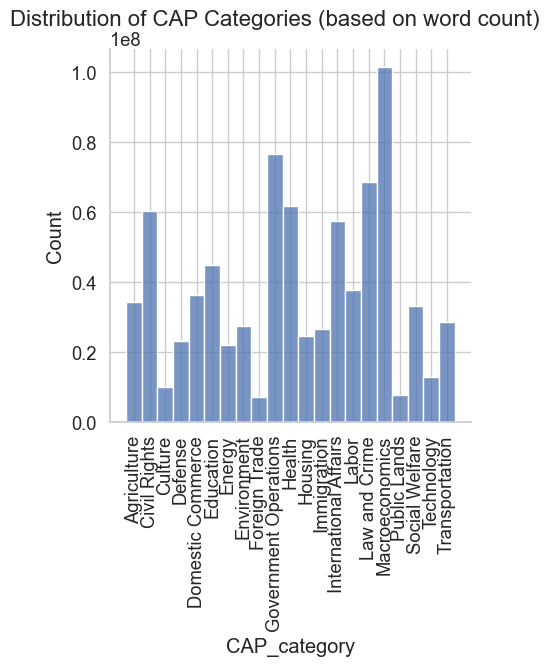

In [11]:
g = sns.displot(
    data=filtered_all.sort_values("CAP_category"),
    x="CAP_category",
    weights=filtered_all["word_count"] 
)

cap_order = sorted(filtered_all["CAP_category"].unique()) #defines order of CAP labels on x axis

g.set_xticklabels(rotation=90)  # rotate x-axis labels
g.fig.suptitle("Distribution of CAP Categories (based on word count)", fontsize=16)
g.fig.subplots_adjust(top=0.9)

*As we can see, topics like "Macroeconomics" and "Government Operations" are discussed the most across all parliaments. But what does it look like on one country level?*

**3.2. Per-country**

This code looks at only **one country at a time**, e.g. "RS", to see what topics are discuseed most in this one country.

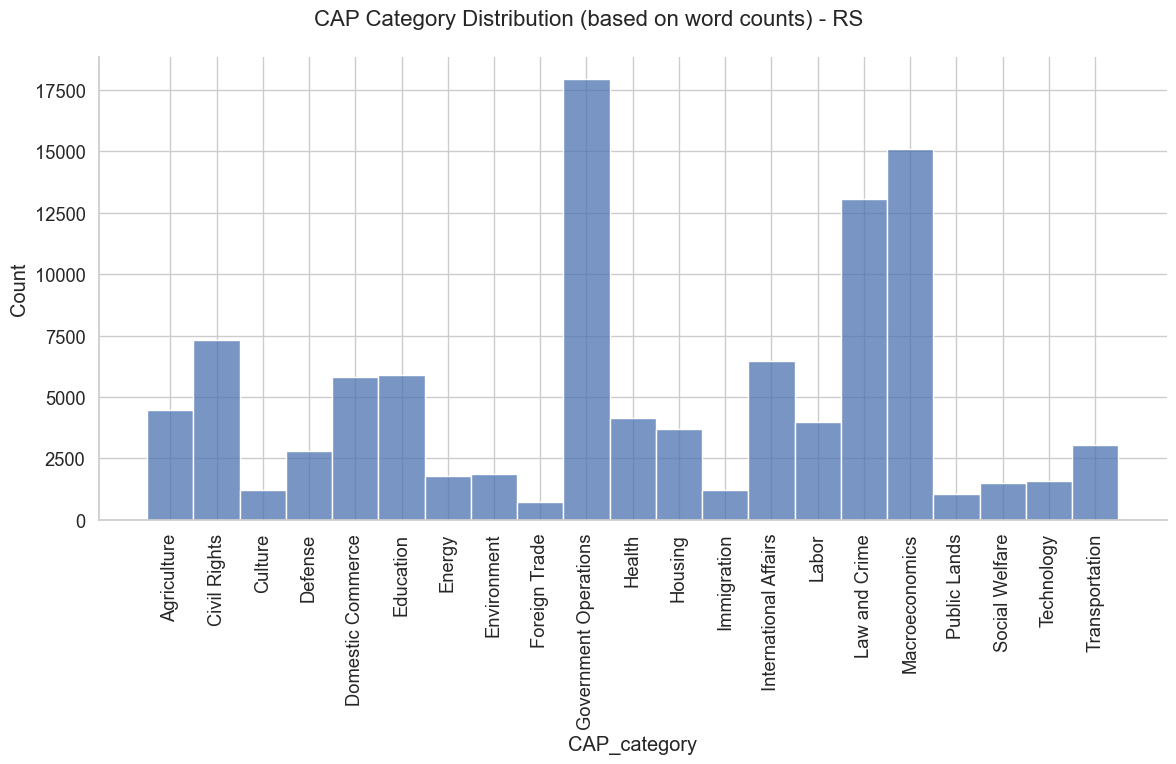

In [12]:
filtered_by_country = filtered_all[filtered_all["country"] == "RS"]  

g = sns.displot(
    data=filtered_by_country.sort_values("CAP_category"),
    x="CAP_category",
    height=6,
    aspect=2
)

g.set_xticklabels(rotation=90)

g.fig.suptitle("CAP Category Distribution (based on word counts) - RS", fontsize=16)
g.fig.subplots_adjust(top=0.9)  


*In this example, it shows that the Serbian parliament devotes most of its time to debate "Government Operations" and "Macroeconimics", as well as "Labor and Crime", similar to the distribution of all countries. If you want to research the distribution for other countries, just change the country abbreviation in the code above.*

**4. Sentiment by Party & Orientation**

In this section, we explore the distribution of sentiment across CAP topics and parties, aiming to answer questions like “How positive, neutral, or negative is the tone of parliamentary debates?”

**4.1. Sentiment Distribution Across Topics for a single country**

Before diving into party-level analyses, it is useful to examine how sentiment is distributed across all CAP topics within a single country. This provides a high-level overview of which topics tend to attract more positive, neutral, or negative speech and sets the stage for more detailed analyses by party or party orientation.

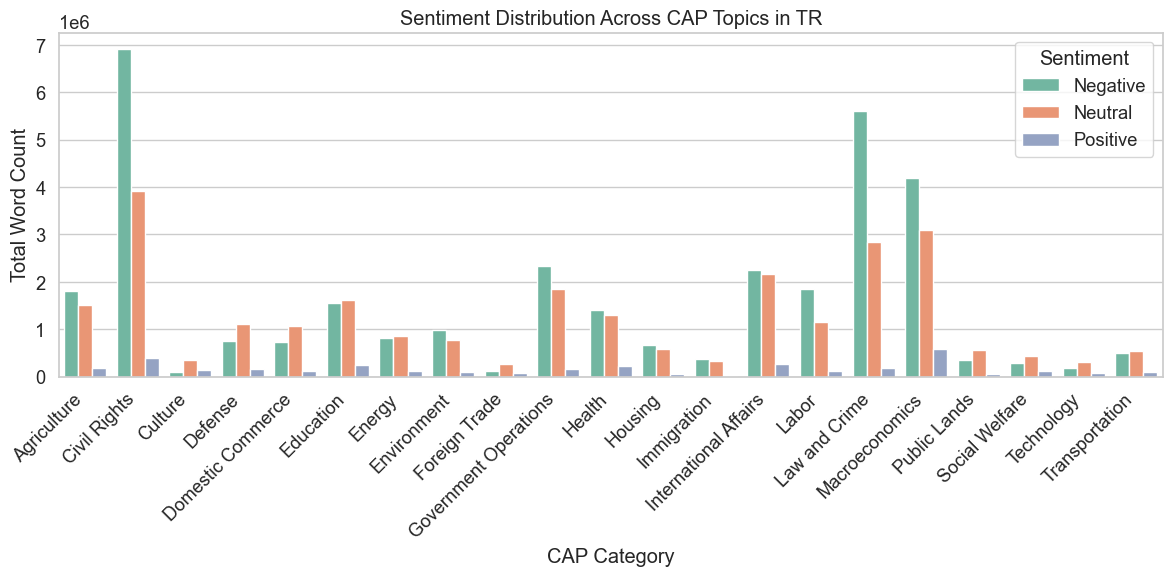

In [18]:
# ---- 1. Filter data for one country ----
country = "TR"  # change to your country of interest
country_data = filtered_all[filtered_all["country"] == country]

# ---- 2. Aggregate word counts by CAP_category and sentiment ----
cap_sent_counts = (
    country_data
    .groupby(["CAP_category", "sent3_category"], observed=True)["word_count"]
    .sum()
    .reset_index()
)

# ---- 3. Ensure CAP_category is ordered consistently ----
cap_order = sorted(country_data["CAP_category"].unique())
cap_sent_counts["CAP_category"] = pd.Categorical(
    cap_sent_counts["CAP_category"],
    categories=cap_order,
    ordered=True
)

# ---- 4. Plot ----
plt.figure(figsize=(12,6))
sns.barplot(
    data=cap_sent_counts,
    x="CAP_category",
    y="word_count",
    hue="sent3_category",
    palette="Set2"
)

plt.title(f"Sentiment Distribution Across CAP Topics in {country}")
plt.xlabel("CAP Category")
plt.ylabel("Total Word Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


*For Turkey, we can identify that the distribution of negative and neutral tone is balanced for most topics, except for "Civil Rights", "Law and Crime" and "Macroeconomics".*

**4.2. Sentiment Distribution across topics for all countries combined**

Having looked at sentiment across CAP topics within a single country, we can now step back and examine patterns across all parliaments. This section visualizes the distribution of positive, neutral, and negative sentiment for each topic aggregated across all countries. By comparing topics on a global scale, we can identify which areas of debate tend to evoke more negative or positive language overall and how these patterns differ from what we observed in the single-country view.


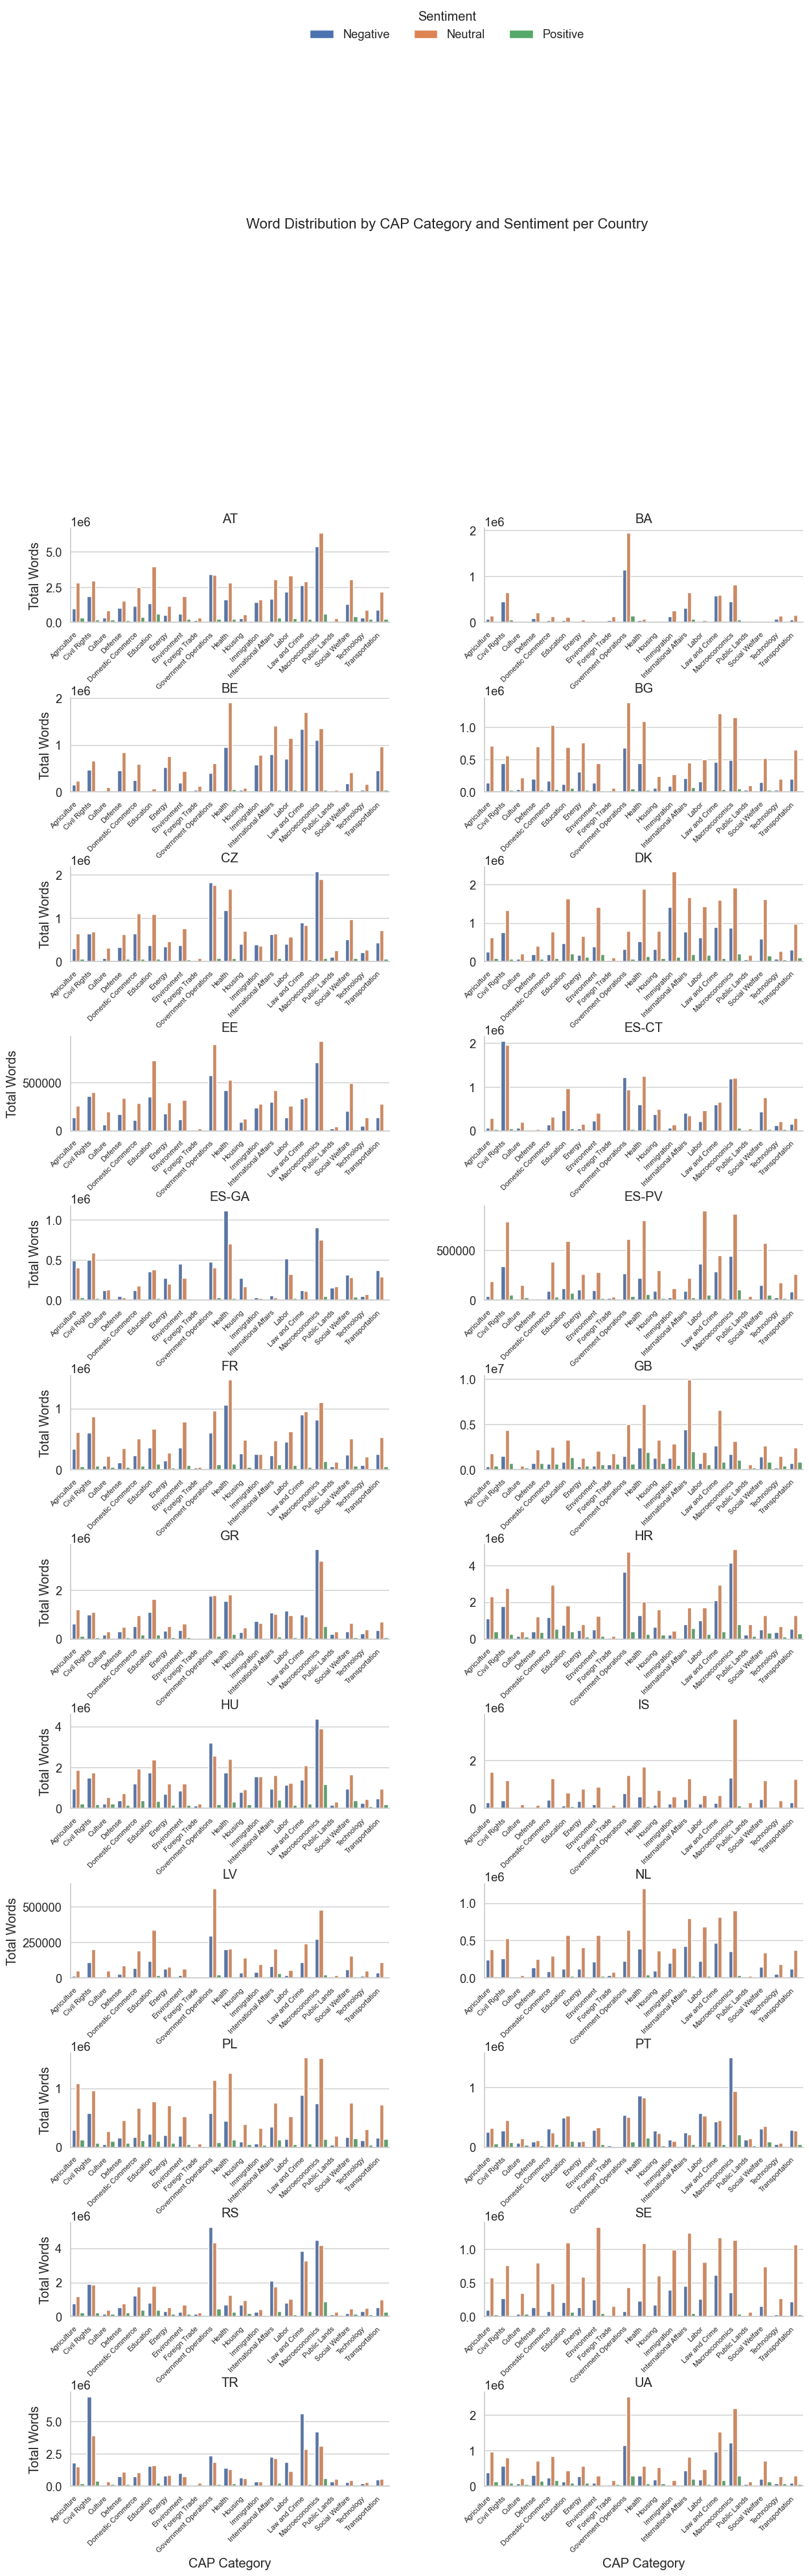

In [13]:
# ---- 1. Aggregate word counts by CAP, sentiment, and country ----
cap_sent_country = (
    filtered_all
    .groupby(["country", "CAP_category", "sent3_category"], observed=True)
    .agg(total_words=("word_count", "sum"))
    .reset_index()
)

# ---- 2. Ensure CAP_category is categorical with fixed order ----
cap_order = sorted(cap_sent_country["CAP_category"].unique())
cap_sent_country["CAP_category"] = pd.Categorical(
    cap_sent_country["CAP_category"],
    categories=cap_order,
    ordered=True
)

# ---- 3. Plot: CAP × sentiment stacked per country ----
g = sns.catplot(
    data=cap_sent_country,
    x="CAP_category",
    y="total_words",
    hue="sent3_category",
    col="country",
    kind="bar",
    height=4,
    aspect=1.6,
    col_wrap=2,
    sharey=False,
    sharex=False,  
    order=cap_order
)

# ---- 3.1. Rotate xticklabels ----
for ax in g.axes.flatten():
    ax.set_xticks(range(len(cap_order)))
    ax.set_xticklabels(cap_order, rotation=45, ha="right", fontsize=8)

g.set_axis_labels("CAP Category", "Total Words")
g.set_titles("{col_name}")

# ---- 3.2. Remove default legend ----
if g._legend:
    g._legend.remove()

# ---- 3.3. Create a **clean legend on top** ----
hue_order = sorted(cap_sent_country["sent3_category"].unique())
palette = sns.color_palette(n_colors=len(hue_order))
legend_elements = [Patch(facecolor=palette[i], label=hue_order[i]) for i in range(len(hue_order))]

g.fig.legend(
    handles=legend_elements,
    loc='upper center',
    ncol=len(hue_order),
    frameon=False,
    bbox_to_anchor=(0.5, 1.05),  # slightly above the plots
    title="Sentiment"
)

# ---- 3.4. Adjust spacing to reduce top margin ----
g.fig.subplots_adjust(top=0.88, bottom=0.25, hspace=0.8)  # top smaller so title & legend closer
g.fig.suptitle("Word Distribution by CAP Category and Sentiment per Country", fontsize=16)

plt.show()


*These plots show that the distribution of sentiment can vary from parliament to parliament. Interestingley, the neutral and negative tones dominate the debates in every parliament. In some coutnries we can also identify some negative outliers: In TR (Turkey) for example, debates about "Civil Rights" are mostly annotated with negative sentiment. We already identified this outlier in our single-country analysis (4.1.) but here, it becomes clear that Turkey and the regional parliament of Catalonia (ES-CA) stand out as the only parliaments with such a pronounced negative focus on this topic.*

*In potential next steps, you could look further into the structure of one parliament to try to identify how extreme values come together.*

**4.2. By party in one country**

The next code looks at **sentiment distribution** per **party** of one chosen country's parliament (to see which parties contribute with a more positive, neutral or negative tone).

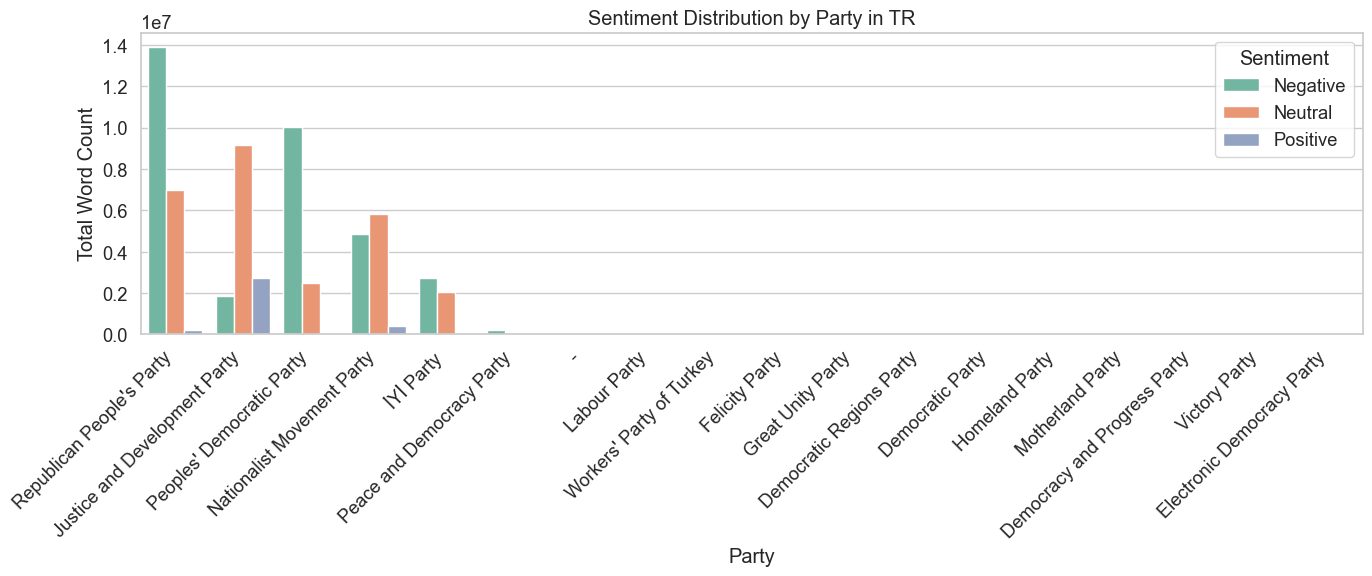

In [14]:
# ---- 1. Filter the data for one country ----
country = "TR"
country_data = filtered_all[filtered_all["country"] == country].copy()

# ---- 2. Aggregate word count by party and sent3_category ----
agg_counts = (
    country_data
    .groupby(["speaker_party_name", "sent3_category"], observed=True)["word_count"]
    .sum()
    .reset_index()
)

# ---- 3. Sort parties by total word count ----
party_order = (
    agg_counts.groupby("speaker_party_name")["word_count"].sum()
    .sort_values(ascending=False)
    .index
)

# ---- 4. Plot ----
plt.figure(figsize=(14, 6))
sns.barplot(
    data=agg_counts,
    x="speaker_party_name",
    y="word_count",
    hue="sent3_category",
    palette="Set2",
    order=party_order
)

plt.title(f"Sentiment Distribution by Party in {country}")
plt.xlabel("Party")
plt.ylabel("Total Word Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

*As we can see, the Republican People's Party emerges as the most active contributor to debates in the Turkish Parliament. However, much of its discourse is characterized by negative sentiment. By contrast, the second most active party maintains a more neutral tone. This pattern could be explored further, for instance by examining whether the negativity reflects a structural opposition role (depending on whether the party is primarily in opposition or in government), or whether it is driven by reactions to particular issues dominating the parliamentary agenda (i.e., the topics most frequently addressed by this party).*

**4.3. Coalition vs. Opposition** (all countries combined)

The code below analyzes the sentiment distribution across party status ("Opposition" / "Coalition" / "-"), helping to answer questions such as “Is the opposition or the coalition more negative?”

At the top, there is an optional (commented-out) section that lets you filter the data by country or even by a specific party. Enabling this filter allows you to examine how sentiment distribution by coalition vs. opposition looks within a particular country or for a specific party.

*Note: The "-" category appears for speeches where party status could not be determined or does not clearly fall into "Coalition" or "Opposition". This may include independent MPs, temporary members, or cases where metadata is missing. Including these speeches in the analysis can slightly influence the overall sentiment distribution, as their contributions may not reflext the typical behavior of coalition and opposition parties. When interpreting results, it's important to consider that the "-" category represents a heterogenous group and may introduce additional variability.*

C:\Users\isabe\AppData\Local\Temp\ipykernel_26312\525027040.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["party_status", "sent3_category"])["word_count"]


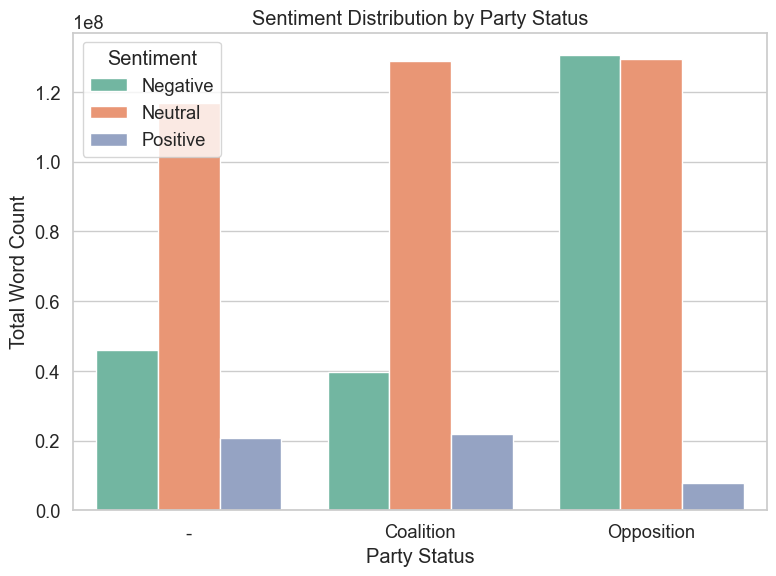

In [ ]:
# ---- 0. Optional: Filter by country and/or party ----
# To filter, uncomment and specify values:
# filtered_all = filtered_all[filtered_all["country"] == "TR"]
# filtered_all = filtered_all[filtered_all["party_name"] == "Republican People's Party"]

# ---- 1. Aggregate word count by party status and sentiment ----
status_word_counts = (
    filtered_all
    .groupby(["party_status", "sent3_category"])["word_count"]
    .sum()
    .reset_index()
)

# ---- 2. Plot sentiment distribution across party status ----
plt.figure(figsize=(8, 6))
sns.barplot(
    data=status_word_counts,
    x="party_status",
    y="word_count",
    hue="sent3_category",
    palette="Set2"
)

plt.title("Sentiment Distribution by Party Status")
plt.xlabel("Party Status")
plt.ylabel("Total Word Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

*This shows us that the Opposition contributes the largest share of words overall to parliamentary debates across all countries. We can also see that much of the Opposition's contribution is characterized by a negative tone. Future research could investigate whether this negativity is structural and happens across all parliaments equally. Additionally, examining how these patterns vary by topic or over time could provide deeper insights into parliamentary discourse dynamics.*

**5. Average Sentiment by Country & Topic**

After examining the distribution of sentiment across topics at both the single-country and multi-country levels, it is useful to summarize these patterns quantitatively. In the next section, we calculate the average sentiment for each country and topic. This will produce a table containing columns for average sentiment and total word count for every topic and country, which can be saved as a TSV file for further research. 

In [31]:
# ---- 1. Compute weighted avg sentiment and total word count ----
agg = (
    filtered_all
    .groupby(["country", "CAP_category"], observed=True)
    .apply(lambda x: pd.Series({
        "avg_sentiment": (x["sent_logit"] * x["word_count"]).sum() / x["word_count"].sum(),
        "total_words": x["word_count"].sum()
    }))
    .reset_index()
)

# ---- 2. Round the sentiment ----
agg["avg_sentiment"] = agg["avg_sentiment"].round(2)

# ---- 3. Ensure total_words is int ----
agg["total_words"] = agg["total_words"].astype(int)

# ---- 4. Optional: sort by country and CAP_category ----
agg = agg.sort_values(by=["country", "CAP_category"])

# ---- 5. Display the table ----
print(agg)

# ---- 6. Export to TSV for further research ----
output_path = "avg_sentiment_by_country_topic.tsv"
agg.to_csv(output_path, sep="\t", index=False)
print(f"\nTSV file saved as: {output_path}")

    country       CAP_category  avg_sentiment  total_words
0        AT        Agriculture           2.18      4115736
1        AT       Civil Rights           1.90      5000275
2        AT            Culture           2.29      1405506
3        AT            Defense           1.91      2722677
4        AT  Domestic Commerce           2.19      4021712
..      ...                ...            ...          ...
499      UA     Macroeconomics           2.06      3684584
500      UA       Public Lands           2.12       190139
501      UA     Social Welfare           2.36      1051246
502      UA         Technology           2.45       421939
503      UA     Transportation           2.33       447973

[504 rows x 4 columns]

TSV file saved as: avg_sentiment_by_country_topic.tsv


C:\Users\isabe\AppData\Local\Temp\ipykernel_18104\1507398074.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


**6. Topic share vs. sentiment across countries (Scatterplots)**

Building on the summarized sentiment statistics from the previous section, we can now explore how the relative emphasis on each topic relates to the tone of parliamentary debates. In this section, we create a scatterplot for all countries combined showing the share of words devoted to a topic versus the average sentiment expressed, providing us with a visual overview of how topic prominence and sentiment interact across countries.

C:\Users\isabe\AppData\Local\Temp\ipykernel_18104\1650621705.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("CAP_category")[["sent_logit", "word_count"]]


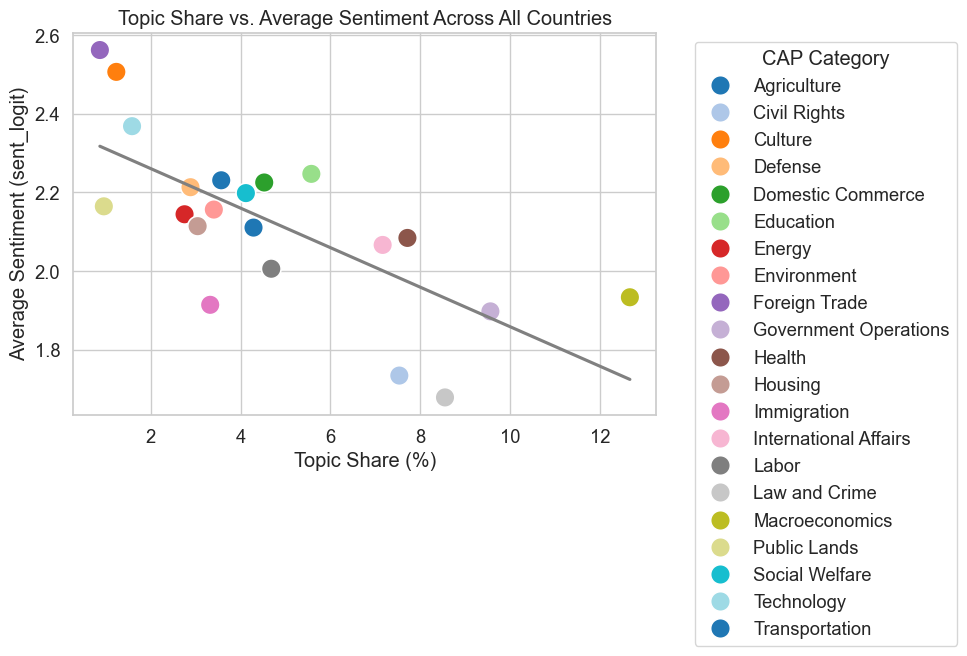

In [40]:
# ---- 1. Aggregate across all countries ----
agg_all = (
    filtered_all
    .groupby("CAP_category")[["sent_logit", "word_count"]]
    .agg(mean_sent=("sent_logit", "mean"),
         total_words=("word_count", "sum"))
    .reset_index()
)

# ---- 2. Calculate topic share across all countries ----
total_words_all = agg_all["total_words"].sum()
agg_all["topic_share_pct"] = (agg_all["total_words"] / total_words_all) * 100

# ---- 3. Scatter plot ----
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg_all,
    x="topic_share_pct",
    y="mean_sent",
    hue="CAP_category",
    palette="tab20",
    s=200
)

# Optional: add regression line
sns.regplot(
    data=agg_all,
    x="topic_share_pct",
    y="mean_sent",
    scatter=False,
    ci=None,
    color="gray"
)

plt.title("Topic Share vs. Average Sentiment Across All Countries")
plt.xlabel("Topic Share (%)")
plt.ylabel("Average Sentiment (sent_logit)")
plt.legend(title="CAP Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


*Across all countries combined, the trend line slopes downward, suggesting that topics receiving more attention tend to be discussed with a slightly more negative tone. However, this aggregated view can hide important country-specific patterns: in some parliaments, discussion is fairly balanced across topics, while in others, one or two topics dominate the debate. To gain deeper insight, it is recommended to create similar scatterplots for individual countries to identify which specific topics drive this negative emphasis.*

**Conclusion:**

This notebook provides a comprehensive overview of topic and sentiment dynamics in parliamentary speeches across multiple countries or for one chosen country. Key findings include:
- **CAP category patterns**: Topics such as *Macroeconomics* and *Government Operations* dominate debates across most parliaments, while the prevalence of other topics varies between countries.
- **Sentiment trends**: Neutral and negative sentiment generally dominate parliamentary debates, with occasional country-specific outliers. For instance, Turky exhibits pronounced negativity in discussions on *Civil Rights*. Only the Catalonian parliament (ES-CA) shows a similar pattern for that topic.
- **Party & Coalition Influence**: The Opposition typically contributes more words and tends to express slightly more negative sentiment, while coalitions often maintain a more neutral tone. 
- **Topic prominence vs. sentiment**: The scatterplot reveals that topics receiving greater attention are discussed more negatively, though some countries might display a more balanced distribution if looked at separately.